# Model

Folder Structure:

#### Root
- Data/
- - Test/                      # Contains evaluation images
- - Train/                     # Contains training images
- - sample_submission.csv      # Sample submission file for Kaggle competition
- - train_labels.csv           # csv file containing training set labels in format (fileName, label)
- Model.ipynb                  # Current file


In [2]:
# Define constants
TRAIN_LABEL_FILE = 'Data/train_labels.csv'
TRAIN_IMAGES_DIR = 'Data/train'
BLOB_ACCOUNT_NAME = 'jtmlblobdatasets'
BLOB_ACCOUNT_KEY = 'aWVS/rVSn7wgHZjQmTOLWi11bs3P33JT2NMd9KYEyWv8pDLvp/a1QbN5KSQdzOGUyp+bm3b5zsZdq8rlUyqBxA=='
BLOB_CONTAINER = 'histcancerdetectiondata'
BLOB_NAME = 'train.zip'
DATASET_ZIP = 'Data/data.zip'
USE_GPU = False

In [4]:
# Imports
from __future__ import print_function, division

import azure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import zipfile

from azure.storage.blob import BlockBlobService
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets

ImportError: No module named 'azure'

In [ ]:
# Download zipped dataset from Azure Blob Storage
training_labels = pd.read_csv(TRAIN_LABEL_FILE)
blob_service = BlockBlobService(account_name = BLOB_ACCOUNT_NAME, account_key = BLOB_ACCOUNT_KEY)

start_time = time.time()

blob_service.get_blob_to_path(container_name = BLOB_CONTAINER, blob_name = BLOB_NAME, file_path = DATASET_ZIP)
    
end_time = time.time()

print('Time to download: {} mins', round((end_time - start_time)/ 60., 2))

In [1]:
# Dataset Class
class PCamDataset(Dataset):
    """Histopathologic Cancer Detection Dataset"""
    def __init__(self, csv_file, root_dir, transform):
        
        """
        Args:
            csv_file (string): Path to the csv file with train labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train_labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.train_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.train_labels.iloc[idx, 0])
        img_name = img_name + '.tif'
        image = Image.open(img_name)
        label = self.train_labels.iloc[idx, 1:].values
        return self.transform(image), int(label)
    
class PCamDatasetFromZip(Dataset):
    """Histopathologic Cancer Detection Dataset"""
    def __init__(self, zip_file, csv_file, transform):
        
        """
        Args:
            csv_file (string): Path to the csv file with train labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.archive = zipfile.ZipFile(zip_file, 'r')
        self.labels = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name = self.labels.iloc[idx, 0] + '.tif'
        image = Image.open(self.archive.open(image_name))
        label = self.labels.iloc[idx, 1:].values
        return self.transform(image), int(label)

NameError: name 'Dataset' is not defined

In [4]:
# Model Class(es)
class CNN_V1(nn.Module):
    """Convolutional Neural Network"""
    def __init__(self):
        super(CNN_V1, self).__init__()
        # 1. Convolutional layers
        self.conv1 = nn.Conv2d( in_channels = 3
                               , out_channels = 16
                               , kernel_size = 3
                               , stride = 1
                               , padding = 1 )
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d( in_channels = 16
                               , out_channels = 32
                               , kernel_size = 3
                               , stride = 1
                               , padding = 1 )
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d( in_channels = 32
                               , out_channels = 64
                               , kernel_size = 3
                               , stride = 1
                               , padding = 1 )
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d( kernel_size = 2
                                 , stride = 2
                                 , padding = 0 )

        # 2. FC layers to final output
        self.fc1 = nn.Linear(in_features = 64*12*12, out_features = 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(in_features = 256, out_features = 1)

    def forward(self, x):
        # Apply 3x...
        # Convolution Layers, followed by Batch Normalizations, Maxpool, and ReLU
        x = self.bn1(self.conv1(x))                      # batch_size x 96 x 96 x 16
        x = self.pool(F.relu(x))                         # batch_size x 48 x 48 x 16
        x = self.bn2(self.conv2(x))                      # batch_size x 48 x 48 x 32
        x = self.pool(F.relu(x))                         # batch_size x 24 x 24 x 32
        x = self.bn3(self.conv3(x))                      # batch_size x 24 x 24 x 64
        x = self.pool(F.relu(x))                         # batch_size x 12 x 12 x 64
        
        # Flatten the output for each image
        x = x.view(-1, self.num_flat_features(x))        # batch_size x 12*12*64
        
        # Apply 3 FC Layers
        x = self.fc1(x)
        x = self.fc_bn1(x)
        x = F.relu(x)
        x = self.fc_bn2(self.fc2(x))
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [5]:
# Helper functions
def show_image(image, label):
    """Show image with label"""
    print('Label: ' + str(label[0]))
    plt.show(image)

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def training_accuracy(predicted, true, i, acc, tpr, tnr):
    """Taken from https://www.kaggle.com/krishanudb/cancer-detection-deep-learning-model-using-pytorch"""
    predicted = predicted.cpu()
    true = true.cpu()
    predicted = (sigmoid(predicted.data.numpy()) > 0.5)
    true = true.data.numpy()
    accuracy = np.sum(predicted == true) / true.shape[0]
    true_positive_rate = np.sum((predicted == 1) * (true == 1)) / np.sum(true == 1)
    true_negative_rate = np.sum((predicted == 0) * (true == 0)) / np.sum(true == 0)
    acc = acc * (i) / (i + 1)  + accuracy / (i + 1)
    tpr = tpr * (i) / (i + 1)  + true_positive_rate / (i + 1)
    tnr = tnr * (i) / (i + 1) + true_negative_rate / (i + 1)
    return acc, tpr, tnr

def dev_accuracy(predicted, target):
    """Taken from https://www.kaggle.com/krishanudb/cancer-detection-deep-learning-model-using-pytorch"""
    predicted = (sigmoid(predicted.data.numpy()) > 0.5)
    true = target.data.numpy()
    accuracy = np.sum(predicted == true) / true.shape[0]
    true_positive_rate = np.sum((predicted == 1) * (true == 1)) / np.sum(true == 1)
    true_negative_rate = np.sum((predicted == 0) * (true == 0)) / np.sum(true == 0)
    return accuracy, true_positive_rate, true_negative_rate

#def batch_accuracy(output, target):
#    pred = torch.gt(output, 0.5)
#    truth = torch.gt(target, 0.5)
#    acc = pred.eq(truth).sum() / target.numel()
#    return acc
#
#def accuracy(data, target): ### Deprecated
#    """Computes the accuracy"""
#    num_tensors = len(data)
#    sum_acc = 0.0
#    for tensor_idx in range(num_tensors):
#        sum_acc += batch_accuracy(data[tensor_idx], target[tensor_idx])
#    return sum_acc / num_tensors * 100

def train_dev_test_split_indices(dataset, train_split=0.8, dev_split=0.1, seed=30):
    """Given a dataset, returns the train/dev/test split indices"""
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_split_end = int(np.floor(train_split * dataset_size))
    dev_split_end = int(np.floor(dev_split * dataset_size)) + train_split_end
    np.random.seed(seed)
    np.random.shuffle(indices)
    train_indices = indices[:train_split_end]
    dev_indices = indices[train_split_end:dev_split_end]
    test_indices = indices[dev_split_end:]
    return train_indices, dev_indices, test_indices

In [6]:
print(CNN_V1())

CNN_V1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc_bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [7]:
# Transformations
x_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
# Parameters
batch_size = 128
num_workers = 0
num_epochs = 10
early_stop_limit = 5
bad_epoch_count = 0
stop = False
train_loss_min = np.Inf

transform = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
# Create DataSet
#dataset = PCamDataset( csv_file = TRAIN_LABEL_FILE
#                      , root_dir = TRAIN_IMAGES_DIR
#                      , transform = transform )
dataset = PCamDatasetFromZip( zip_file = DATASET_ZIP
                             , csv_file = TRAIN_LABEL_FILE
                             , transform = transform )

# Create data indices for train/dev set split
train_indices, dev_indices, test_indices = train_dev_test_split_indices(dataset)

######################################################
### Starting with smaller samplers to ramp up ###
######################################################
train_subset_size = 2500
dev_subset_size = 500
train_indices = train_indices[:train_subset_size]
dev_indices = dev_indices[:dev_subset_size]
######################################################

train_sampler = SubsetRandomSampler(train_indices)   # 176,020 Images (Full) / [train_subset_size] Images (Subset)
dev_sampler   = SubsetRandomSampler(dev_indices)     # 22,002 Images (Full) / [dev_subset_size] Images (Subset)
test_sampler  = SubsetRandomSampler(test_indices)    # 22,003 Images

train_loader = DataLoader( dataset = dataset
                          , batch_size = batch_size
                          , num_workers = num_workers
                          , sampler = train_sampler )
dev_loader = DataLoader( dataset = dataset
                          , batch_size = batch_size
                          , num_workers = num_workers
                          , sampler = dev_sampler )

In [14]:
# Model
model = CNN_V1()
model.load_state_dict(torch.load('model_v1.pt'))
if (USE_GPU):
    model.cuda()

In [15]:
# Optimizer and loss criterion
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCEWithLogitsLoss()

In [16]:
train_loss_arr = []
train_acc_arr = []
train_tpr_arr = []
train_tnr_arr = []

dev_loss_arr = []
dev_acc_arr = []
dev_tpr_arr = []
dev_tnr_arr = []

# Loop over the dataset multiple times
for epoch in range(num_epochs):

    # Keep track of training loss
    train_loss = 0.0
    
    # Keep track of dev loss
    dev_loss = 0.0
    
    # Test accuracy
    loss_temp = []
    acc, tpr, tnr = 0., 0., 0.

    # Train the model
    start_time = time.time()
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        if USE_GPU:
            data, target = image.cuda(), label.cuda()
        else:
            data, target = image, label
            
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Update target to be the same dimensions as output
        target = target.view(output.shape[0],1).float()
        
        # Get accuracy measurements
        acc, tpr, tnr = training_accuracy(output, target, batch_idx, acc, tpr, tnr)

        # Calculate the batch's loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Save loss for loss plot
        loss_temp.append(loss.item())
        
        # Perform a single optimization step to update parameters
        optimizer.step()
        
        # Update the training loss
        train_loss += loss.item()
        
        # Print debug info
        if (batch_idx) % 4 == 0:
            print('Epoch {}/{}; Iter {}/{}; Loss: {:.4f}; Acc: {:.3f}; True Pos: {:.3f}; True Neg: {:.3f}'
                   .format(epoch+1, num_epochs, batch_idx + 1, len(train_loader), loss.item(), acc, tpr, tnr))
    
    end_time = time.time()
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(dev_loader):
            if USE_GPU:
                data, target = image.cuda(), label.cuda()
            else:
                data, target = image, label

            # Get predicted output
            output = model(data)

            # Update target to be the same dimensions as output
            target = target.view(output.shape[0],1).float()

            # Get accuracy measurements
            dev_acc, dev_tpr, dev_tnr = dev_accuracy(output, target)
            
            # Calculate the batch's loss
            curr_dev_loss = criterion(output, target)

            # Update the dev loss
            dev_loss += curr_dev_loss.item()
            
    # Update dev loss arrays
    dev_loss_arr.append(curr_dev_loss)
    dev_acc_arr.append(dev_acc)
    dev_tpr_arr.append(dev_tpr)
    dev_tnr_arr.append(dev_tnr)

    print('Epoch {}/{}; Loss: {:.4f}; Train Acc: {:.3f}; Train TPR: {:.3f}; Train TNR: {:.3f}; Epoch Time: {} mins; \nDev Loss: {:.4f}; Dev Acc: {:.3f}; Dev TPR: {:.3f}; Dev TNR: {:.3f}\n'
           .format(epoch+1, num_epochs, loss, acc, tpr, tnr, round((end_time - start_time)/ 60., 2), curr_dev_loss, dev_acc, dev_tpr, dev_tnr))
    
    # Training loss arrays
    train_loss_arr.append(np.mean(np.array(loss_temp)))
    train_acc_arr.append(acc)
    train_tpr_arr.append(tpr)
    train_tnr_arr.append(tnr)
    
    # Calculate average loss
    train_loss = train_loss/len(train_loader.dataset)
    dev_loss = dev_loss/len(dev_loader.dataset)
    
    # Save model if train loss has decreased
    ### Focused on train loss at the moment because we want to overfit ###
    ### the training data before worrying about our variance.          ###
    if train_loss <= train_loss_min:
        print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
              .format(train_loss_min, train_loss))
        torch.save(model.state_dict(), 'model_v1.pt')
        train_loss_min = train_loss
        bad_epoch_count = 0
    # If train loss didn't improve, increase bad_epoch_count and stop if
    # bad_epoch_count >= early_stop_limit (early stop)
    else:
        bad_epoch_count += 1
        print('{} epochs of increasing training loss'.format(bad_epoch_count))
        if (bad_epoch_count >= early_stop_limit):
            print('Stopping training')
            stop = True
        
    if (stop):
        break

Epoch 1/10; Iter 1/20; Loss: 0.0014; Acc: 1.000; True Pos: 1.000; True Neg: 1.000
Epoch 1/10; Iter 5/20; Loss: 0.0208; Acc: 0.997; True Pos: 0.996; True Neg: 0.998
Epoch 1/10; Iter 9/20; Loss: 0.0011; Acc: 0.994; True Pos: 0.994; True Neg: 0.994
Epoch 1/10; Iter 13/20; Loss: 0.0393; Acc: 0.993; True Pos: 0.991; True Neg: 0.995
Epoch 1/10; Iter 17/20; Loss: 0.0455; Acc: 0.990; True Pos: 0.986; True Neg: 0.994
Epoch 1/10; Loss: 0.2067; Train Acc: 0.988; Train TPR: 0.984; Train TNR: 0.992; Epoch Time: 0.56 mins; 
Dev Loss: 1.6063; Dev Acc: 0.750; Dev TPR: 0.511; Dev TNR: 0.913

Train loss decreased (inf --> 0.000003).  Saving model ...
Epoch 2/10; Iter 1/20; Loss: 0.0095; Acc: 1.000; True Pos: 1.000; True Neg: 1.000
Epoch 2/10; Iter 5/20; Loss: 0.0559; Acc: 0.983; True Pos: 0.985; True Neg: 0.982
Epoch 2/10; Iter 9/20; Loss: 0.0166; Acc: 0.986; True Pos: 0.984; True Neg: 0.989
Epoch 2/10; Iter 13/20; Loss: 0.0057; Acc: 0.989; True Pos: 0.986; True Neg: 0.992
Epoch 2/10; Iter 17/20; Loss: 

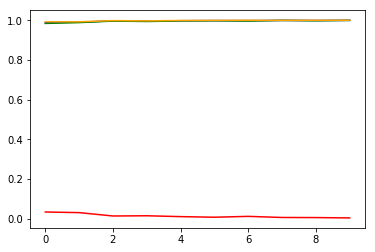

In [18]:
#Training set plot
plt.plot(train_loss_arr, color="red")
plt.plot(train_acc_arr, color="blue")
plt.plot(train_tpr_arr, color="green")
plt.plot(train_tnr_arr, color="orange")
plt.show()

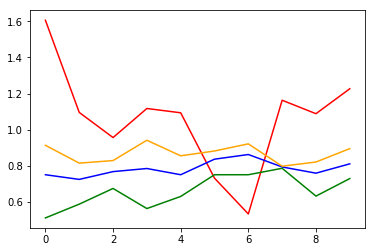

In [19]:
#Dev set plot
plt.plot(dev_loss_arr, color="red")
plt.plot(dev_acc_arr, color="blue")
plt.plot(dev_tpr_arr, color="green")
plt.plot(dev_tnr_arr, color="orange")
plt.show()